In [1]:
#Imports
import pandas as pd
import csv
from api_keys import census_api
import json
import requests
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

In [22]:
#Input
traffic_data = "./Resources/US_Accidents_March23.csv"

In [23]:
traffic_df=pd.read_csv(traffic_data)
traffic_df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [24]:
#Creating DataFrame w/ reduced columns
reduced_traffic_df = traffic_df[["Start_Time","End_Time","Severity","City","State","Weather_Condition",
                                 "Temperature(F)","Visibility(mi)","Wind_Speed(mph)","Precipitation(in)",\
                                 "Sunrise_Sunset","Description","Bump","Crossing", "Give_Way","Junction",\
                                 "No_Exit","Railway","Roundabout","Station","Stop","Traffic_Calming",\
                                 "Traffic_Signal","Turning_Loop"
                                ]]
reduced_traffic_df.shape

(7728394, 24)

In [25]:
#dropping NA
drop_traffic_df = reduced_traffic_df.dropna(how='any')
drop_traffic_df.shape

(5382749, 24)

In [26]:
#Using function to pars
def parse_time(raw):
    date = dt.datetime.fromisoformat(raw).date()
    string = date.isoformat()
    return string

In [27]:
drop_traffic_df.loc[:, "Start_Date"] = drop_traffic_df['Start_Time'].map(parse_time)
drop_traffic_df.loc[:, "End_Date"] = drop_traffic_df['End_Time'].map(parse_time)
drop_traffic_df.head()

/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_3500/3272619180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_traffic_df.loc[:, "Start_Date"] = drop_traffic_df['Start_Time'].map(parse_time)
/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_3500/3272619180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_traffic_df.loc[:, "End_Date"] = drop_traffic_df['End_Time'].map(parse_time)


,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Start_Date,End_Date
5,2016-02-08 07:44:26,2016-02-08 08:14:26,3,Westerville,OH,Light Rain,37.9,7.0,3.5,0.03,...,False,False,False,False,False,False,False,False,2016-02-08,2016-02-08
9,2016-02-08 08:10:04,2016-02-08 08:40:04,3,Westerville,OH,Light Rain,37.4,3.0,4.6,0.02,...,False,False,False,False,False,False,False,False,2016-02-08,2016-02-08
11,2016-02-08 08:21:27,2016-02-08 08:51:27,3,Reynoldsburg,OH,Light Rain,37.4,3.0,4.6,0.02,...,False,False,False,False,False,False,False,False,2016-02-08,2016-02-08
14,2016-02-08 08:39:43,2016-02-08 09:09:43,2,Columbus,OH,Light Rain,37.4,3.0,4.6,0.02,...,False,False,False,False,False,False,True,False,2016-02-08,2016-02-08
20,2016-02-08 10:11:15,2016-02-08 10:41:15,2,Columbus,OH,Light Snow,33.8,2.0,4.6,0.01,...,False,False,False,False,False,False,False,False,2016-02-08,2016-02-08


In [28]:
def year(raw):
    year_string = raw[:4]
    year_integer = int(year_string)
    return year_integer  

In [29]:
drop_traffic_df.loc[:, "Start_Year"] = drop_traffic_df['Start_Date'].map(year)
drop_traffic_df.loc[:, "End_Year"] = drop_traffic_df['End_Date'].map(year)
drop_traffic_df

/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_3500/3370142283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_traffic_df.loc[:, "Start_Year"] = drop_traffic_df['Start_Date'].map(year)
/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_3500/3370142283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_traffic_df.loc[:, "End_Year"] = drop_traffic_df['End_Date'].map(year)


,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Start_Date,End_Date,Start_Year,End_Year
5,2016-02-08 07:44:26,2016-02-08 08:14:26,3,Westerville,OH,Light Rain,37.9,7.0,3.5,0.03,...,False,False,False,False,False,False,2016-02-08,2016-02-08,2016,2016
9,2016-02-08 08:10:04,2016-02-08 08:40:04,3,Westerville,OH,Light Rain,37.4,3.0,4.6,0.02,...,False,False,False,False,False,False,2016-02-08,2016-02-08,2016,2016
11,2016-02-08 08:21:27,2016-02-08 08:51:27,3,Reynoldsburg,OH,Light Rain,37.4,3.0,4.6,0.02,...,False,False,False,False,False,False,2016-02-08,2016-02-08,2016,2016
14,2016-02-08 08:39:43,2016-02-08 09:09:43,2,Columbus,OH,Light Rain,37.4,3.0,4.6,0.02,...,False,False,False,False,True,False,2016-02-08,2016-02-08,2016,2016
20,2016-02-08 10:11:15,2016-02-08 10:41:15,2,Columbus,OH,Light Snow,33.8,2.0,4.6,0.01,...,False,False,False,False,False,False,2016-02-08,2016-02-08,2016,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7728389,2019-08-23 18:03:25,2019-08-23 18:32:01,2,Riverside,CA,Fair,86.0,10.0,13.0,0.00,...,False,False,False,False,False,False,2019-08-23,2019-08-23,2019,2019
7728390,2019-08-23 19:11:30,2019-08-23 19:38:23,2,San Diego,CA,Fair,70.0,10.0,6.0,0.00,...,False,False,False,False,False,False,2019-08-23,2019-08-23,2019,2019
7728391,2019-08-23 19:00:21,2019-08-23 19:28:49,2,Orange,CA,Partly Cloudy,73.0,10.0,10.0,0.00,...,False,False,False,False,False,False,2019-08-23,2019-08-23,2019,2019
7728392,2019-08-23 19:00:21,2019-08-23 19:29:42,2,Culver City,CA,Fair,71.0,10.0,8.0,0.00,...,False,False,False,False,False,False,2019-08-23,2019-08-23,2019,2019


In [30]:
drop_traffic_df.count()

Start_Time           5382749
End_Time             5382749
Severity             5382749
City                 5382749
State                5382749
Weather_Condition    5382749
Temperature(F)       5382749
Visibility(mi)       5382749
Wind_Speed(mph)      5382749
Precipitation(in)    5382749
Sunrise_Sunset       5382749
Description          5382749
Bump                 5382749
Crossing             5382749
Give_Way             5382749
Junction             5382749
No_Exit              5382749
Railway              5382749
Roundabout           5382749
Station              5382749
Stop                 5382749
Traffic_Calming      5382749
Traffic_Signal       5382749
Turning_Loop         5382749
Start_Date           5382749
End_Date             5382749
Start_Year           5382749
End_Year             5382749
dtype: int64

In [88]:
#reorganizing columns
organized_traffic_df = drop_traffic_df[["Start_Year","Start_Date","End_Year","End_Date","Start_Time","End_Time",\
                                        "Severity","City","State","Weather_Condition","Temperature(F)","Visibility(mi)",\
                                        "Wind_Speed(mph)","Precipitation(in)","Sunrise_Sunset","Description","Bump",\
                                        "Crossing", "Give_Way","Junction","No_Exit","Railway","Roundabout","Station",\
                                        "Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"]]
organized_traffic_df.head()

,Start_Year,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
5,2016,2016-02-08,2016,2016-02-08,2016-02-08 07:44:26,2016-02-08 08:14:26,3,Westerville,OH,Light Rain,...,False,False,False,False,False,False,False,False,False,False
9,2016,2016-02-08,2016,2016-02-08,2016-02-08 08:10:04,2016-02-08 08:40:04,3,Westerville,OH,Light Rain,...,False,False,False,False,False,False,False,False,False,False
11,2016,2016-02-08,2016,2016-02-08,2016-02-08 08:21:27,2016-02-08 08:51:27,3,Reynoldsburg,OH,Light Rain,...,False,False,False,False,False,False,False,False,False,False
14,2016,2016-02-08,2016,2016-02-08,2016-02-08 08:39:43,2016-02-08 09:09:43,2,Columbus,OH,Light Rain,...,False,False,False,False,False,False,False,False,True,False
20,2016,2016-02-08,2016,2016-02-08,2016-02-08 10:11:15,2016-02-08 10:41:15,2,Columbus,OH,Light Snow,...,False,False,False,False,False,False,False,False,False,False


In [93]:
organized_traffic_gp = organized_traffic_df.groupby(["Start_Year"]).count()
organized_traffic_gp

,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
Start_Year,,,,,,,,,,,,,,,,,,,,,
2016,32696,32696,32696,32696,32696,32696,32696,32696,32696,32696,...,32696,32696,32696,32696,32696,32696,32696,32696,32696,32696
2017,77775,77775,77775,77775,77775,77775,77775,77775,77775,77775,...,77775,77775,77775,77775,77775,77775,77775,77775,77775,77775
2018,106716,106716,106716,106716,106716,106716,106716,106716,106716,106716,...,106716,106716,106716,106716,106716,106716,106716,106716,106716,106716
2019,718540,718540,718540,718540,718540,718540,718540,718540,718540,718540,...,718540,718540,718540,718540,718540,718540,718540,718540,718540,718540
2020,1096220,1096220,1096220,1096220,1096220,1096220,1096220,1096220,1096220,1096220,...,1096220,1096220,1096220,1096220,1096220,1096220,1096220,1096220,1096220,1096220
2021,1467720,1467720,1467720,1467720,1467720,1467720,1467720,1467720,1467720,1467720,...,1467720,1467720,1467720,1467720,1467720,1467720,1467720,1467720,1467720,1467720
2022,1652684,1652684,1652684,1652684,1652684,1652684,1652684,1652684,1652684,1652684,...,1652684,1652684,1652684,1652684,1652684,1652684,1652684,1652684,1652684,1652684
2023,230398,230398,230398,230398,230398,230398,230398,230398,230398,230398,...,230398,230398,230398,230398,230398,230398,230398,230398,230398,230398


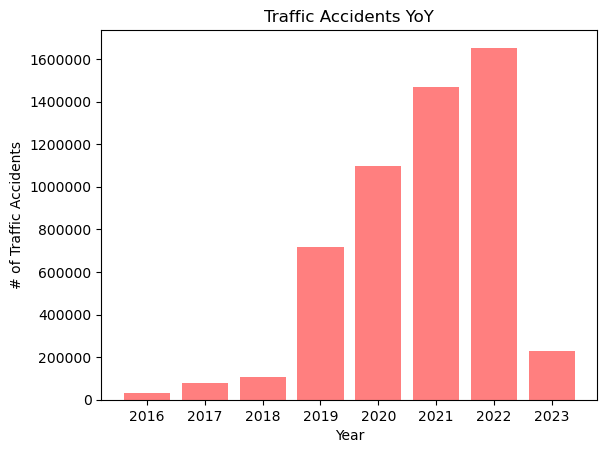

In [94]:
x_axis=organized_traffic_gp.index.tolist()
y_axis = organized_traffic_gp["State"].tolist()

plt.ticklabel_format(style='plain')
plt.bar(x_axis, y_axis,color='r',alpha=0.5, align="center")
plt.title("Traffic Accidents YoY")
plt.xlabel("Year")
plt.ylabel("# of Traffic Accidents")
plt.show()

In [ ]:
city_traffic = organized_traffic_df.groupby("City")
city_traffic_count = city_traffic.count().sort_values(by=["State"],ascending=False)
city_traffic_count.head(10)
#[city_traffic_count["State"] >=100000]


In [3]:
#Calling Census API
base_url = "https://api.census.gov/data/2021/acs/acs5?get=NAME,B01003_001E&for=place:*&in=state:*"
api_url = f"{base_url}&key={census_api}"
json_url = requests.get(api_url).json()
print(api_url)

https://api.census.gov/data/2021/acs/acs5?get=NAME,B01003_001E&for=place:*&in=state:*&key=9adc74e4cfc4d4a300ce521d201d867bcab7e31a


In [4]:
#Creating DataFrame from API
df = pd.DataFrame(json_url)
df

,0,1,2,3
0,NAME,B01003_001E,state,place
1,"Abanda CDP, Alabama",231,01,00100
2,"Abbeville city, Alabama",2231,01,00124
3,"Adamsville city, Alabama",4381,01,00460
4,"Addison town, Alabama",697,01,00484
...,...,...,...,...
31904,"Voladoras comunidad, Puerto Rico",696,72,87638
31905,"Yabucoa zona urbana, Puerto Rico",6466,72,87863
31906,"Yauco zona urbana, Puerto Rico",15404,72,88035
31907,"Yaurel comunidad, Puerto Rico",927,72,88121


In [5]:
#renaming column headers
df.columns=["City","Population","State(num)","Place(num)"]
df.head()

,City,Population,State(num),Place(num)
0,NAME,B01003_001E,state,place
1,"Abanda CDP, Alabama",231,01,00100
2,"Abbeville city, Alabama",2231,01,00124
3,"Adamsville city, Alabama",4381,01,00460
4,"Addison town, Alabama",697,01,00484


In [6]:
#drop original column
drop = df.drop([0,0])
drop

,City,Population,State(num),Place(num)
1,"Abanda CDP, Alabama",231,01,00100
2,"Abbeville city, Alabama",2231,01,00124
3,"Adamsville city, Alabama",4381,01,00460
4,"Addison town, Alabama",697,01,00484
5,"Akron town, Alabama",385,01,00676
...,...,...,...,...
31904,"Voladoras comunidad, Puerto Rico",696,72,87638
31905,"Yabucoa zona urbana, Puerto Rico",6466,72,87863
31906,"Yauco zona urbana, Puerto Rico",15404,72,88035
31907,"Yaurel comunidad, Puerto Rico",927,72,88121


In [7]:
#Splitting City and State
split_cl = drop["City"].str.split(',',expand=True)
split_cl

,0,1,2
1,Abanda CDP,Alabama,None
2,Abbeville city,Alabama,None
3,Adamsville city,Alabama,None
4,Addison town,Alabama,None
5,Akron town,Alabama,None
...,...,...,...
31904,Voladoras comunidad,Puerto Rico,None
31905,Yabucoa zona urbana,Puerto Rico,None
31906,Yauco zona urbana,Puerto Rico,None
31907,Yaurel comunidad,Puerto Rico,None


In [8]:
#Renaming Column Header
split_cl.columns=["City_1","State",""]
split_cl

,City_1,State,
1,Abanda CDP,Alabama,None
2,Abbeville city,Alabama,None
3,Adamsville city,Alabama,None
4,Addison town,Alabama,None
5,Akron town,Alabama,None
...,...,...,...
31904,Voladoras comunidad,Puerto Rico,None
31905,Yabucoa zona urbana,Puerto Rico,None
31906,Yauco zona urbana,Puerto Rico,None
31907,Yaurel comunidad,Puerto Rico,None


In [9]:
df =pd.concat([drop,split_cl],axis=1)
drop_df = df.drop([""],axis=1)
drop_df.head()

,City,Population,State(num),Place(num),City_1,State
1,"Abanda CDP, Alabama",231,01,00100,Abanda CDP,Alabama
2,"Abbeville city, Alabama",2231,01,00124,Abbeville city,Alabama
3,"Adamsville city, Alabama",4381,01,00460,Adamsville city,Alabama
4,"Addison town, Alabama",697,01,00484,Addison town,Alabama
5,"Akron town, Alabama",385,01,00676,Akron town,Alabama


In [10]:
def trim(raw):
    trim = raw.strip()
    return trim

In [11]:
drop_df["State"]= drop_df["State"].map(trim)
drop_df

,City,Population,State(num),Place(num),City_1,State
1,"Abanda CDP, Alabama",231,01,00100,Abanda CDP,Alabama
2,"Abbeville city, Alabama",2231,01,00124,Abbeville city,Alabama
3,"Adamsville city, Alabama",4381,01,00460,Adamsville city,Alabama
4,"Addison town, Alabama",697,01,00484,Addison town,Alabama
5,"Akron town, Alabama",385,01,00676,Akron town,Alabama
...,...,...,...,...,...,...
31904,"Voladoras comunidad, Puerto Rico",696,72,87638,Voladoras comunidad,Puerto Rico
31905,"Yabucoa zona urbana, Puerto Rico",6466,72,87863,Yabucoa zona urbana,Puerto Rico
31906,"Yauco zona urbana, Puerto Rico",15404,72,88035,Yauco zona urbana,Puerto Rico
31907,"Yaurel comunidad, Puerto Rico",927,72,88121,Yaurel comunidad,Puerto Rico


In [12]:
census_clean_df = drop_df.rename(columns={"City":"City_State","City_1":"City"})
census_clean_df

,City_State,Population,State(num),Place(num),City,State
1,"Abanda CDP, Alabama",231,01,00100,Abanda CDP,Alabama
2,"Abbeville city, Alabama",2231,01,00124,Abbeville city,Alabama
3,"Adamsville city, Alabama",4381,01,00460,Adamsville city,Alabama
4,"Addison town, Alabama",697,01,00484,Addison town,Alabama
5,"Akron town, Alabama",385,01,00676,Akron town,Alabama
...,...,...,...,...,...,...
31904,"Voladoras comunidad, Puerto Rico",696,72,87638,Voladoras comunidad,Puerto Rico
31905,"Yabucoa zona urbana, Puerto Rico",6466,72,87863,Yabucoa zona urbana,Puerto Rico
31906,"Yauco zona urbana, Puerto Rico",15404,72,88035,Yauco zona urbana,Puerto Rico
31907,"Yaurel comunidad, Puerto Rico",927,72,88121,Yaurel comunidad,Puerto Rico


In [13]:
organized_census_df = census_clean_df[["City","State","Population","State(num)","Place(num)","City_State" 
]]
organized_census_df

,City,State,Population,State(num),Place(num),City_State
1,Abanda CDP,Alabama,231,01,00100,"Abanda CDP, Alabama"
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama"
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama"
4,Addison town,Alabama,697,01,00484,"Addison town, Alabama"
5,Akron town,Alabama,385,01,00676,"Akron town, Alabama"
...,...,...,...,...,...,...
31904,Voladoras comunidad,Puerto Rico,696,72,87638,"Voladoras comunidad, Puerto Rico"
31905,Yabucoa zona urbana,Puerto Rico,6466,72,87863,"Yabucoa zona urbana, Puerto Rico"
31906,Yauco zona urbana,Puerto Rico,15404,72,88035,"Yauco zona urbana, Puerto Rico"
31907,Yaurel comunidad,Puerto Rico,927,72,88121,"Yaurel comunidad, Puerto Rico"


In [14]:
census_clean_df = organized_census_df[(organized_census_df["City"].str.contains("city")) \
                                      & (organized_census_df["State"] != "Puerto Rico")]
census_clean_df

,City,State,Population,State(num),Place(num),City_State
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama"
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama"
6,Alabaster city,Alabama,33133,01,00820,"Alabaster city, Alabama"
7,Albertville city,Alabama,22268,01,00988,"Albertville city, Alabama"
8,Alexander City city,Alabama,14765,01,01132,"Alexander City city, Alabama"
...,...,...,...,...,...,...
31572,Riverton city,Wyoming,10619,56,66220,"Riverton city, Wyoming"
31575,Rock Springs city,Wyoming,23505,56,67235,"Rock Springs city, Wyoming"
31580,Sheridan city,Wyoming,18660,56,69845,"Sheridan city, Wyoming"
31598,Torrington city,Wyoming,6196,56,77530,"Torrington city, Wyoming"


In [15]:
census_clean_df

,City,State,Population,State(num),Place(num),City_State
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama"
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama"
6,Alabaster city,Alabama,33133,01,00820,"Alabaster city, Alabama"
7,Albertville city,Alabama,22268,01,00988,"Albertville city, Alabama"
8,Alexander City city,Alabama,14765,01,01132,"Alexander City city, Alabama"
...,...,...,...,...,...,...
31572,Riverton city,Wyoming,10619,56,66220,"Riverton city, Wyoming"
31575,Rock Springs city,Wyoming,23505,56,67235,"Rock Springs city, Wyoming"
31580,Sheridan city,Wyoming,18660,56,69845,"Sheridan city, Wyoming"
31598,Torrington city,Wyoming,6196,56,77530,"Torrington city, Wyoming"


In [16]:
census_clean_df["Population"] = census_clean_df["Population"].astype(int)


/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_3500/2463147141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_clean_df["Population"] = census_clean_df["Population"].astype(int)


In [20]:
census_clean_df.sort_values("Population",ascending=False).head(10)

,City,State,Population,State(num),Place(num),City_State
18852,New York city,New York,8736047,36,51000,"New York city, New York"
2880,Los Angeles city,California,3902440,06,44000,"Los Angeles city, California"
6707,Chicago city,Illinois,2742119,17,14000,"Chicago city, Illinois"
27206,Houston city,Texas,2293288,48,35000,"Houston city, Texas"
24381,Philadelphia city,Pennsylvania,1596865,42,60000,"Philadelphia city, Pennsylvania"
1227,Phoenix city,Arizona,1591119,04,55000,"Phoenix city, Arizona"
27957,San Antonio city,Texas,1434540,48,65000,"San Antonio city, Texas"
3302,San Diego city,California,1385398,06,66000,"San Diego city, California"
26867,Dallas city,Texas,1300239,48,19000,"Dallas city, Texas"
3312,San Jose city,California,1013337,06,68000,"San Jose city, California"


In [70]:
city = "San Diego City city"
new = city.strip("city")
trim = new.strip()
print(trim)

San Diego City


In [77]:
def strip(raw):
    city = raw.strip("city")
    trim = city.strip()
    return trim

In [78]:
census_clean_df["City2"] = census_clean_df["City"].map(strip)
census_clean_df

/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_3500/3467919659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_clean_df["City2"] = census_clean_df["City"].map(strip)


,City,State,Population,State(num),Place(num),City_State,City2
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama",Abbeville
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama",Adamsville
6,Alabaster city,Alabama,33133,01,00820,"Alabaster city, Alabama",Alabaster
7,Albertville city,Alabama,22268,01,00988,"Albertville city, Alabama",Albertville
8,Alexander City city,Alabama,14765,01,01132,"Alexander City city, Alabama",Alexander City
...,...,...,...,...,...,...,...
31572,Riverton city,Wyoming,10619,56,66220,"Riverton city, Wyoming",Riverton
31575,Rock Springs city,Wyoming,23505,56,67235,"Rock Springs city, Wyoming",Rock Springs
31580,Sheridan city,Wyoming,18660,56,69845,"Sheridan city, Wyoming",Sheridan
31598,Torrington city,Wyoming,6196,56,77530,"Torrington city, Wyoming",Torrington


In [79]:
test1= census_clean_df.rename(columns={"City": "City1","City2": "City"})
test1


,City1,State,Population,State(num),Place(num),City_State,City
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama",Abbeville
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama",Adamsville
6,Alabaster city,Alabama,33133,01,00820,"Alabaster city, Alabama",Alabaster
7,Albertville city,Alabama,22268,01,00988,"Albertville city, Alabama",Albertville
8,Alexander City city,Alabama,14765,01,01132,"Alexander City city, Alabama",Alexander City
...,...,...,...,...,...,...,...
31572,Riverton city,Wyoming,10619,56,66220,"Riverton city, Wyoming",Riverton
31575,Rock Springs city,Wyoming,23505,56,67235,"Rock Springs city, Wyoming",Rock Springs
31580,Sheridan city,Wyoming,18660,56,69845,"Sheridan city, Wyoming",Sheridan
31598,Torrington city,Wyoming,6196,56,77530,"Torrington city, Wyoming",Torrington
